# Conditional Gaussian on a sphere

## Setup

In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging
from mpl_toolkits.mplot3d import Axes3D

sys.path.append("../../")

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


## Load results

In [2]:
setup_filenames = [
    "2_3_0.010",
    "2_3_0.001",
    "2_3_0.100",
]
setup_labels = [
    r"$\epsilon = 0.01$",
    r"$\epsilon = 0.001$",
    r"$\epsilon = 0.1$",
]

In [3]:
algo_filenames = []
algo_additionals = []
algo_labels = []
algo_colors = []
algo_markers = []
algo_linestyles = []

def add_algo(filename, add, label, c, m, ls):
    algo_filenames.append(filename)
    algo_additionals.append(add)
    algo_labels.append(label)
    algo_colors.append(c)
    algo_markers.append(m)
    algo_linestyles.append(ls)
    
    
add_algo("flow", "_small", "Flow", "0.6", "s", "-")
add_algo("pie", "_small", "PIE", "C1", "s", "-") 
add_algo("mf", "_small", "MAD AF", "C3", "s", "-")
add_algo("gamf", "_small_largebs", "OT MAD AF", "C0", "s", "-")

add_algo("pie_specified", "_small", "Prescr. PIE", "C1", "o", "--") 
add_algo("mf_specified", "_small", "Prescr. MAD AF", "C3", "o", "--") 
add_algo("gamf_specified", "_small_largebs", "Prescr. OT MAD AF", "C0", "o", "--")


In [4]:
def load(quantity, shape, numpyfy=True, result_dir="../data/results"):
    all_results = []
    
    for algo_filename, algo_add in zip(algo_filenames, algo_additionals):
        results = []
        
        for setup_filename in setup_filenames:
            try:
                results.append(np.load(
                    "{}/{}_2_conditional_spherical_gaussian_{}{}_{}.npy".format(
                        result_dir, algo_filename, setup_filename, algo_add, quantity
                    )
                ))
            except FileNotFoundError as e:
                print(e)
                results.append(np.nan*np.ones(shape))
            
        all_results.append(results)
    
    return np.asarray(all_results) if numpyfy else all_results

true_posterior_samples = load("true_posterior_samples", (1000,2))
model_posterior_samples = load("model_posterior_samples", (1000, 2))
mmds = load("mmd", (1,))

true_test_log_likelihood = load("true_log_likelihood_test", (11*11, 1000,))
model_test_log_likelihood = load("model_log_likelihood_test", (11*11, 1000,))
model_test_reco_error = load("model_reco_error_test", (1000,))
parameter_grid = load("parameter_grid_test", (11*11,2))

model_test_log_likelihood.shape

(7, 3, 121, 1000)

In [5]:
x_test = np.asarray([
    np.load("../data/samples/conditional_spherical_gaussian/conditional_spherical_gaussian_{}_x_test.npy".format(setup_filename))
    for setup_filename in setup_filenames
])

true_distances = np.abs(np.sum(x_test**2, axis=-1)**0.5 - 1.)

In [6]:
true_expected_nll = -2. * np.mean(true_test_log_likelihood, axis=-1)
model_expected_nll = -2. * np.mean(model_test_log_likelihood, axis=-1)

n_observed = 20
true_observed_nll = -2. * np.sum(true_test_log_likelihood[:,:,:,:n_observed], axis=-1)
model_observed_nll = -2. * np.sum(model_test_log_likelihood[:,:,:,:n_observed], axis=-1)

## Plot eval likelihood on test samples

[0. 0.]


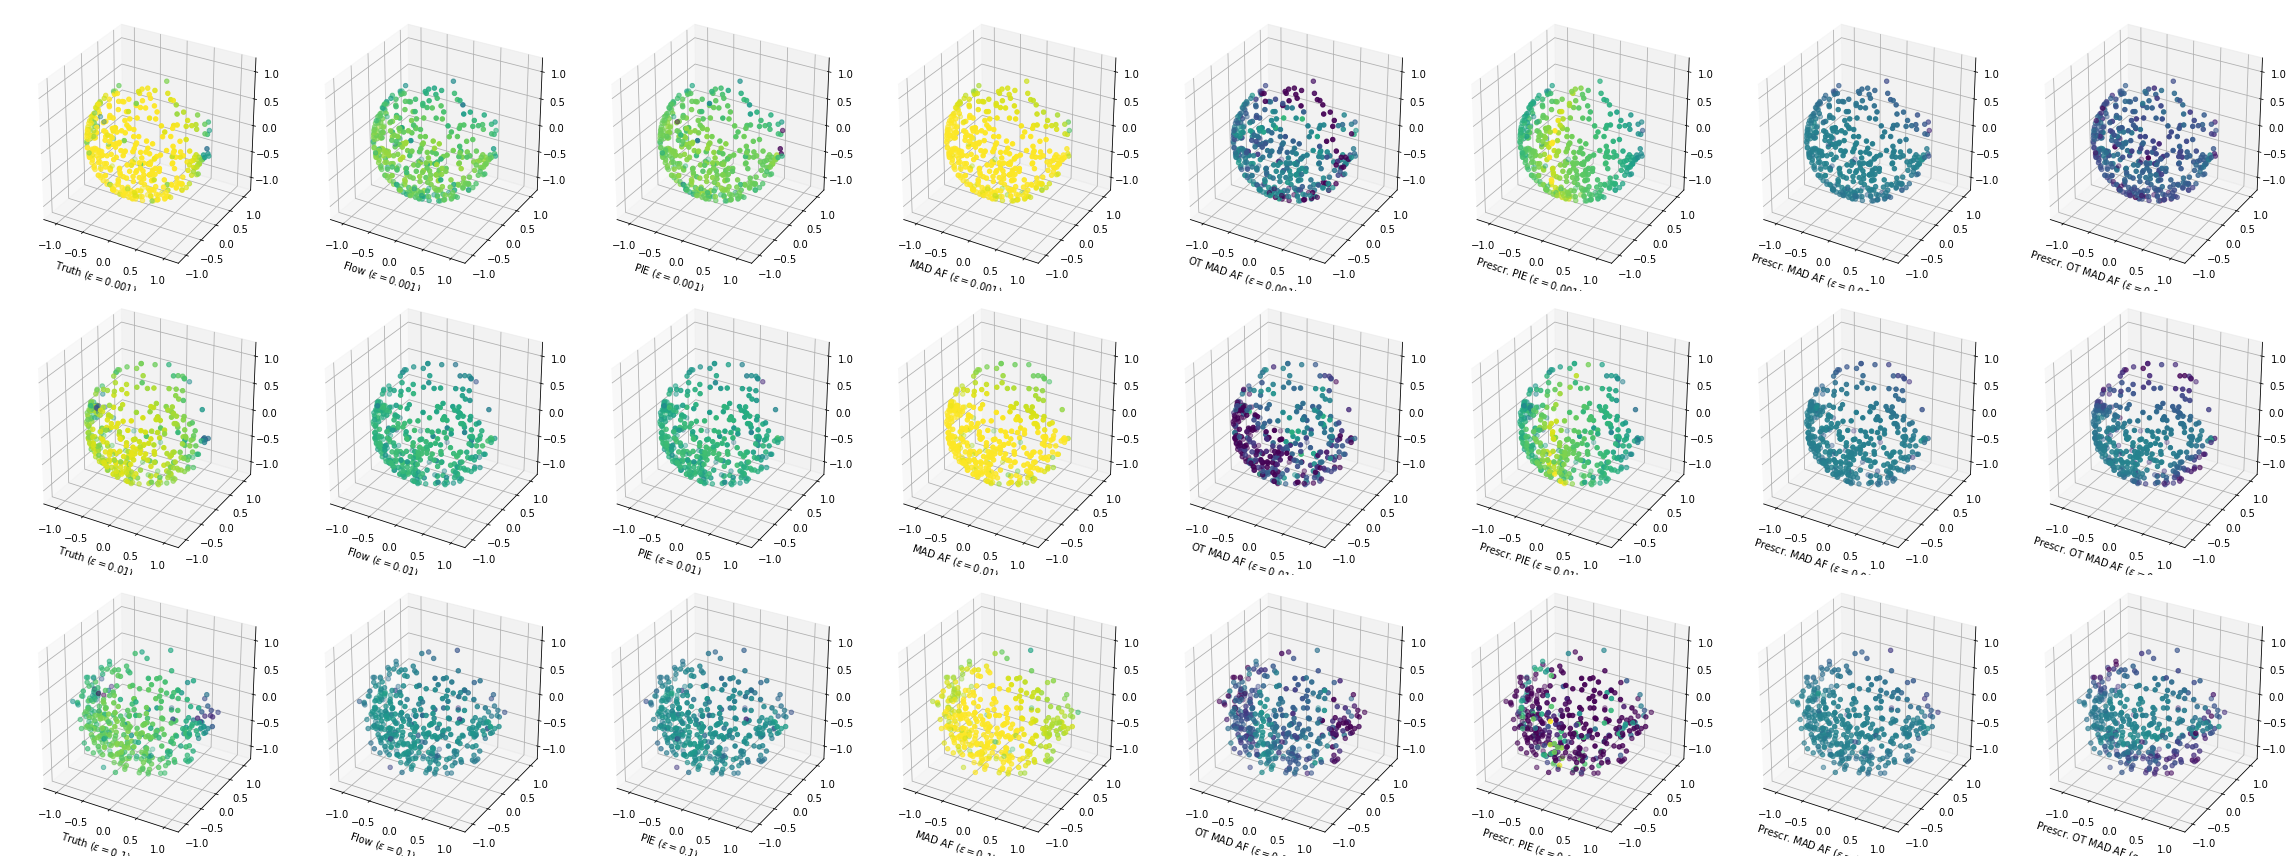

In [7]:
i_grid = 5*11 + 5
print(parameter_grid[0,0,i_grid])

cmin, cmax = -8., 7.
boundary = 1.2
show = [1,0,2]

ncols = len(algo_labels) + 1
nrows = len(show)

fig = plt.figure(figsize=(ncols*4, nrows*4))

for col, algo in enumerate(range(-1, len(algo_labels))):
    for row, setup in enumerate(show):
        x = x_test[setup, :400]
        logp = np.clip(
            true_test_log_likelihood[0, setup, i_grid, :400] if algo < 0 else model_test_log_likelihood[algo, setup, i_grid, :400],
            cmin, cmax
        )
        
        ax = fig.add_subplot(nrows, ncols, row * ncols + col + 1, projection="3d")
        ax.scatter(x[:,0], x[:,1], x[:,2], c=logp, vmin=cmin, vmax=cmax, cmap="viridis")

        ax.set_xlim(-boundary, boundary)
        ax.set_ylim(-boundary, boundary)
        ax.set_zlim(-boundary, boundary)
        ax.set_xlabel(("Truth" if algo < 0 else algo_labels[algo]) + " ({})".format(setup_labels[setup]))
        ax.set_ylabel("")
        ax.set_zlabel("")

plt.tight_layout()
plt.savefig("../figures/test_likelihood_3d_csg.pdf")


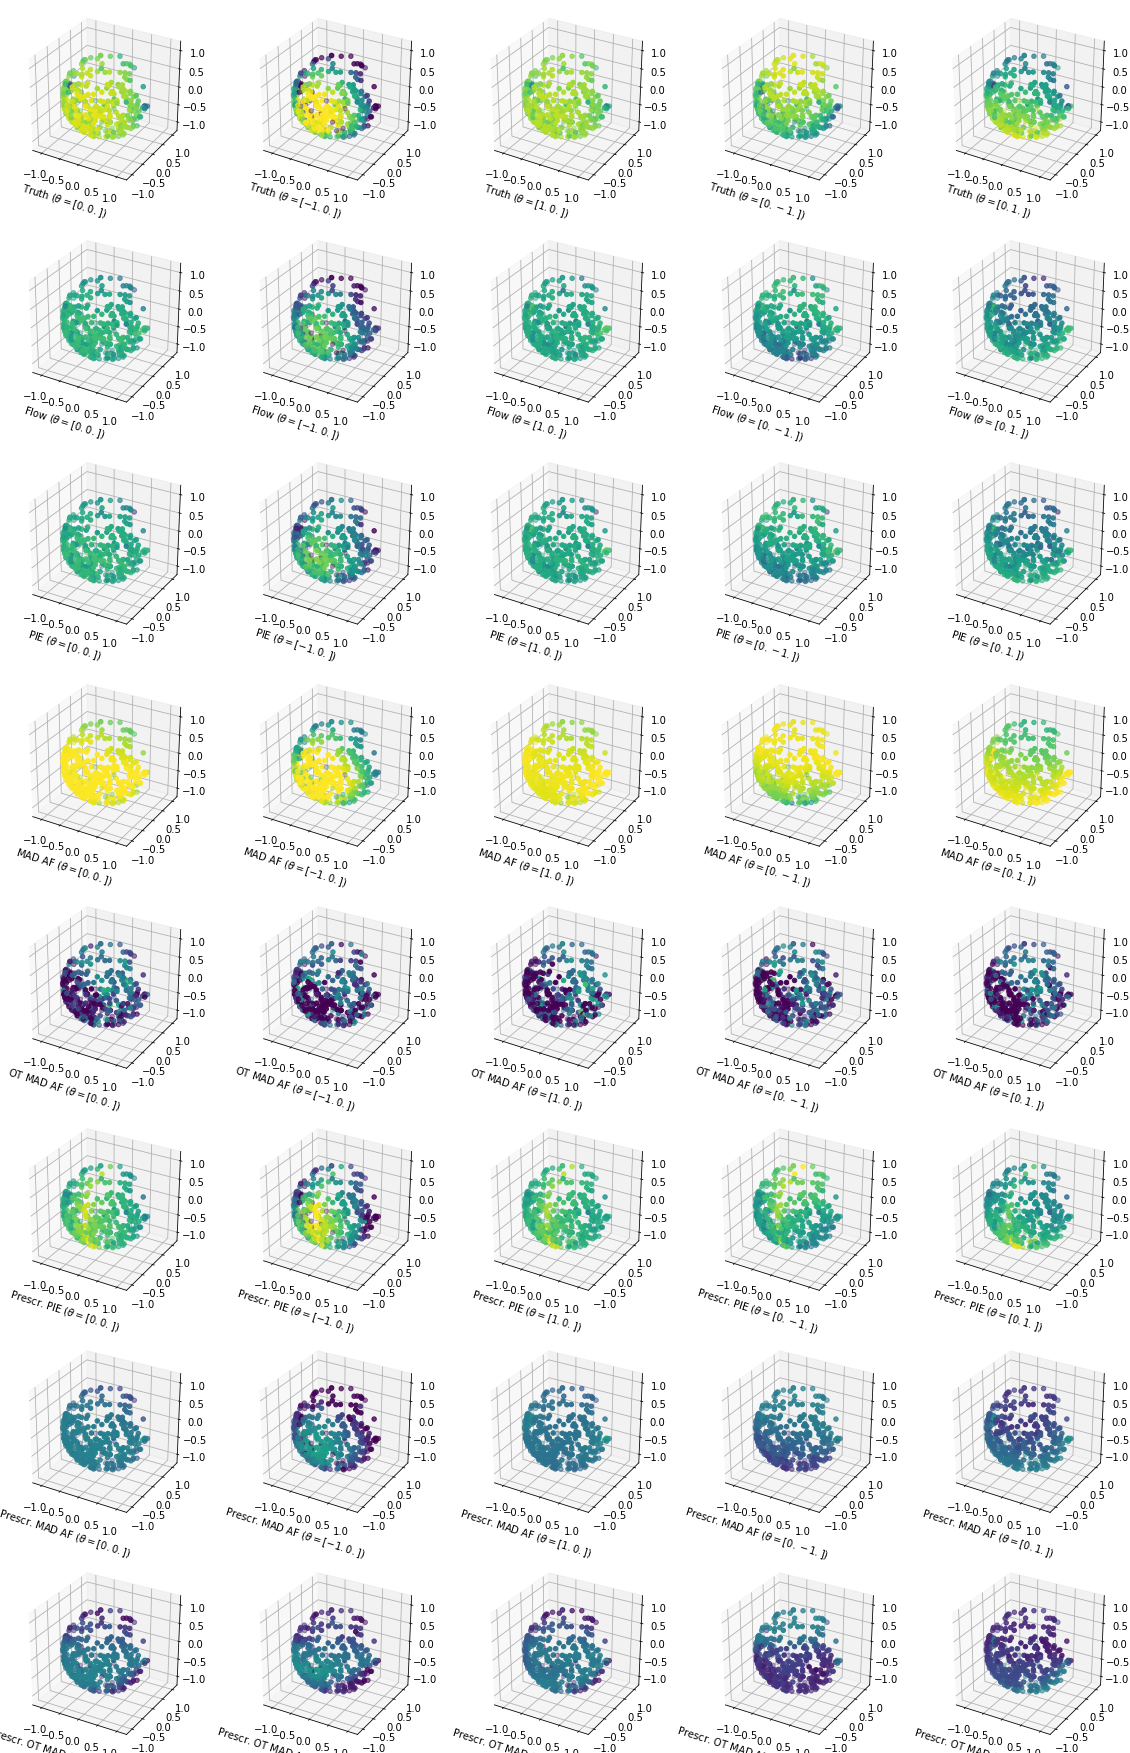

In [8]:
i_grids = [5*11 + 5, 0*11 + 5, 10*11 + 5, 5*11 + 0, 5*11 + 10]
setup = 0

cmin, cmax = -8., 7.
boundary = 1.2

nrows = len(algo_labels) + 1
ncols = len(i_grids)

fig = plt.figure(figsize=(ncols*4, nrows*4))

for row, algo in enumerate(range(-1, len(algo_labels))):
    for col, i_grid in enumerate(i_grids):
        x = x_test[setup, :400]
        logp = np.clip(
            true_test_log_likelihood[0, setup, i_grid, :400] if algo < 0 else model_test_log_likelihood[algo, setup, i_grid, :400],
            cmin, cmax
        )
        
        ax = fig.add_subplot(nrows, ncols, row * ncols + col + 1, projection="3d")
        ax.scatter(x[:,0], x[:,1], x[:,2], c=logp, vmin=cmin, vmax=cmax, cmap="viridis")

        ax.set_xlim(-boundary, boundary)
        ax.set_ylim(-boundary, boundary)
        ax.set_zlim(-boundary, boundary)
        ax.set_xlabel(("Truth" if algo < 0 else algo_labels[algo]) + r" ($\theta = {}$)".format(parameter_grid[0,0,i_grid]))
        ax.set_ylabel("")
        ax.set_zlabel("")

# plt.tight_layout()
plt.savefig("../figures/test_likelihood_vs_params_3d_csg.pdf")

## Expected likelihood maps

/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':


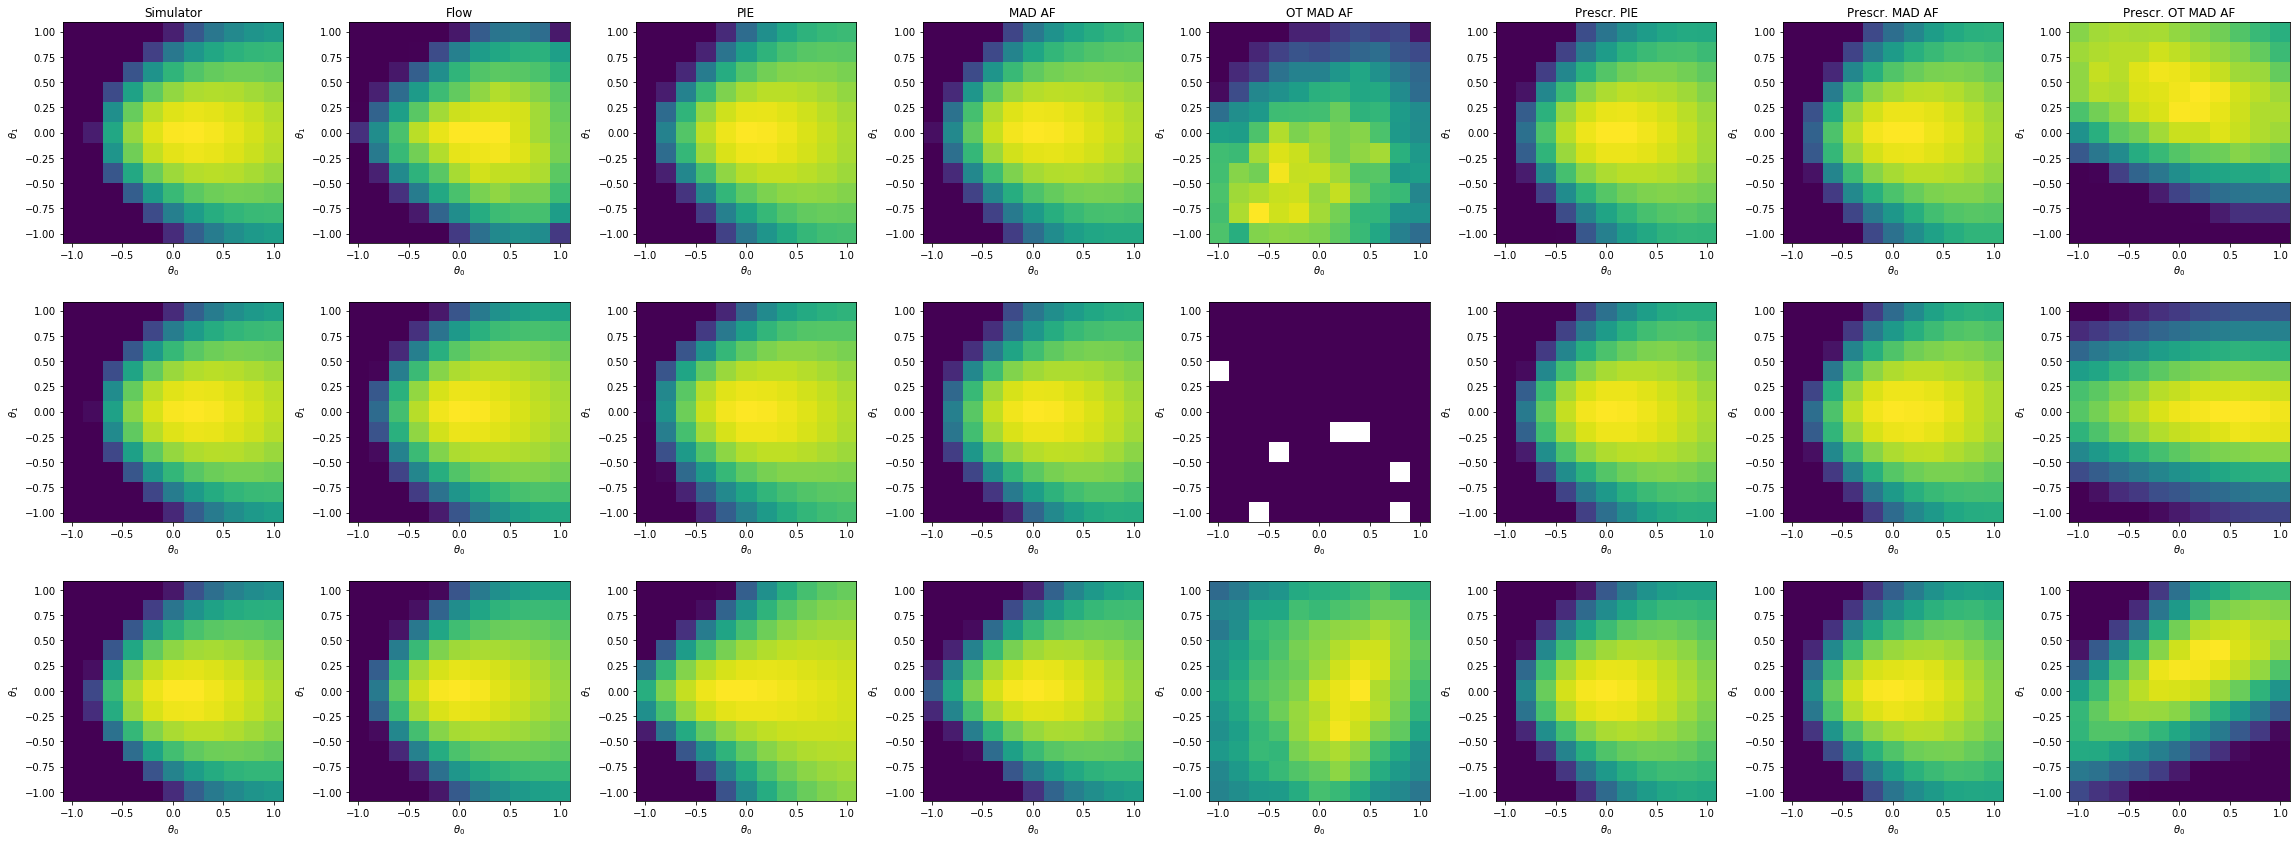

In [9]:
cmin, cmax = 0.,4.
show = [1,0,2]

ncols = len(algo_labels) + 1
nrows = len(show)

fig = plt.figure(figsize=(ncols*4, nrows*4))

for col, algo in enumerate(range(-1, len(algo_labels))):
    for row, setup in enumerate(show):
        logp = true_expected_nll[0, setup] if algo < 0 else model_expected_nll[algo, setup]
        logp = logp - np.min(logp)
        logp = np.clip(logp, cmin, cmax).reshape((11,11))
        
        ax = fig.add_subplot(nrows, ncols, row * ncols + col + 1)
        extent = (-1. - 0.5 * 2. / 11, 1. + 0.5 * 2. / 11, -1. - 0.5 * 2. / 11, 1. + 0.5 * 2. / 11)
        im = plt.imshow(logp.T, extent=extent, vmin=cmin, vmax=cmax, origin="lower", cmap="viridis_r")

        ax.set_xlabel((r"$\theta_0$ - Truth" if algo < 0 else algo_labels[algo]) + " ({})".format(setup_labels[setup]))
        ax.set_ylabel(r"$\theta_1$")
        
        if row == 0:
            ax.set_title("Simulator" if algo < 0 else algo_labels[algo])

        ax.set_xlabel(r"$\theta_0$")
        ax.set_ylabel(r"$\theta_1$")
        
        if row == 0:
            ax.set_title("Simulator" if algo < 0 else algo_labels[algo])

plt.tight_layout()
plt.savefig("../figures/test_expected_likelihood_maps_csg.pdf")



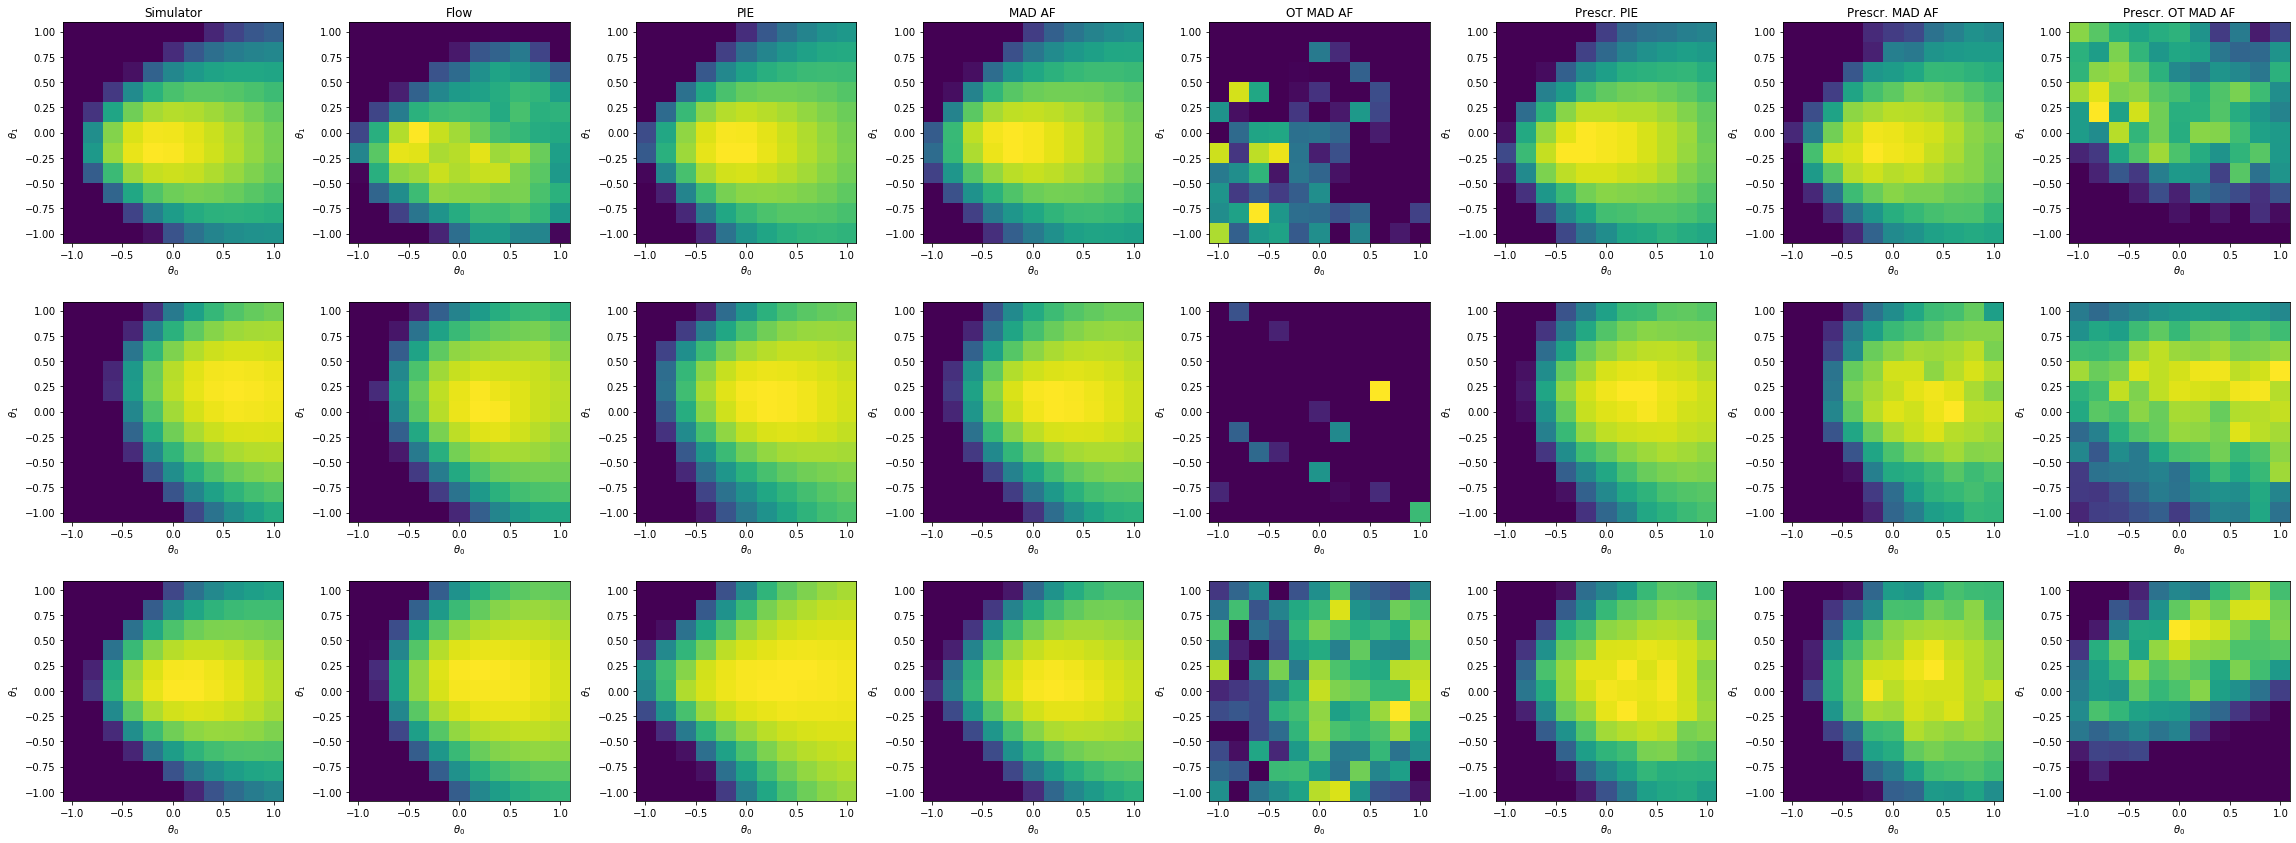

In [10]:
cmin, cmax = 0.,4.*n_observed
show = [1,0,2]

ncols = len(algo_labels) + 1
nrows = len(show)

fig = plt.figure(figsize=(ncols*4, nrows*4))

for col, algo in enumerate(range(-1, len(algo_labels))):
    for row, setup in enumerate(show):
        logp = true_observed_nll[0, setup] if algo < 0 else model_observed_nll[algo, setup]
        logp = logp - np.min(logp)
        logp = np.clip(logp, cmin, cmax).reshape((11,11))
        
        ax = fig.add_subplot(nrows, ncols, row * ncols + col + 1)
        extent = (-1. - 0.5 * 2. / 11, 1. + 0.5 * 2. / 11, -1. - 0.5 * 2. / 11, 1. + 0.5 * 2. / 11)
        im = plt.imshow(logp.T, extent=extent, vmin=cmin, vmax=cmax, origin="lower", cmap="viridis_r")

        ax.set_xlabel(r"$\theta_0$")
        ax.set_ylabel(r"$\theta_1$")
        
        if row == 0:
            ax.set_title("Simulator" if algo < 0 else algo_labels[algo])

plt.tight_layout()
plt.savefig("../figures/test_observed_likelihood_maps_csg.pdf")





## Test likelihood scatter

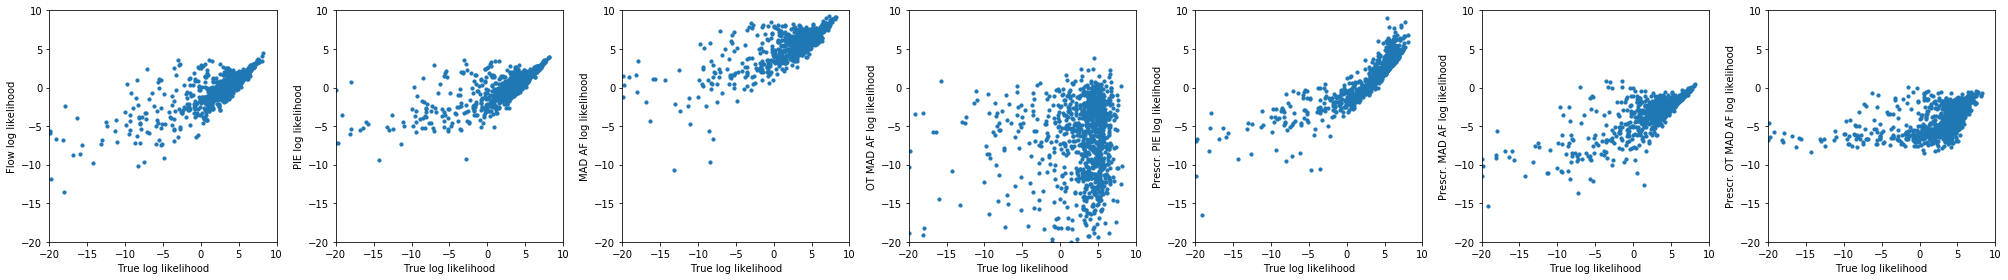

In [11]:
show = [0]
skip = 113

ncols = len(algo_labels)
nrows = len(show)

fig = plt.figure(figsize=(ncols*4, nrows*4))

for row, setting in enumerate(show):
    for col, algo_label in enumerate(algo_labels):
        ax = plt.subplot(nrows, ncols, setting*ncols + col + 1)
        sc = plt.scatter(
            true_test_log_likelihood[col, setting].flatten()[::skip],
            model_test_log_likelihood[col, setting].flatten()[::skip],
            # c=model_test_reco_error[col, setting].flatten(),
            s=10.,
            label=algo_label,
            # cmap="viridis_r",
            # vmin=0., vmax=1.
        )
        # cbar = plt.colorbar(sc)
        
        plt.xlabel(r"True log likelihood")
        plt.ylabel(r"{} log likelihood".format(algo_label))
        # cbar.set_label('Reconstruction error')
        
        plt.xlim(-20, 10)
        plt.ylim(-20, 10)
    
plt.tight_layout()
plt.savefig("../figures/test_likelihood_scatter_csg.pdf")



## MCMC results

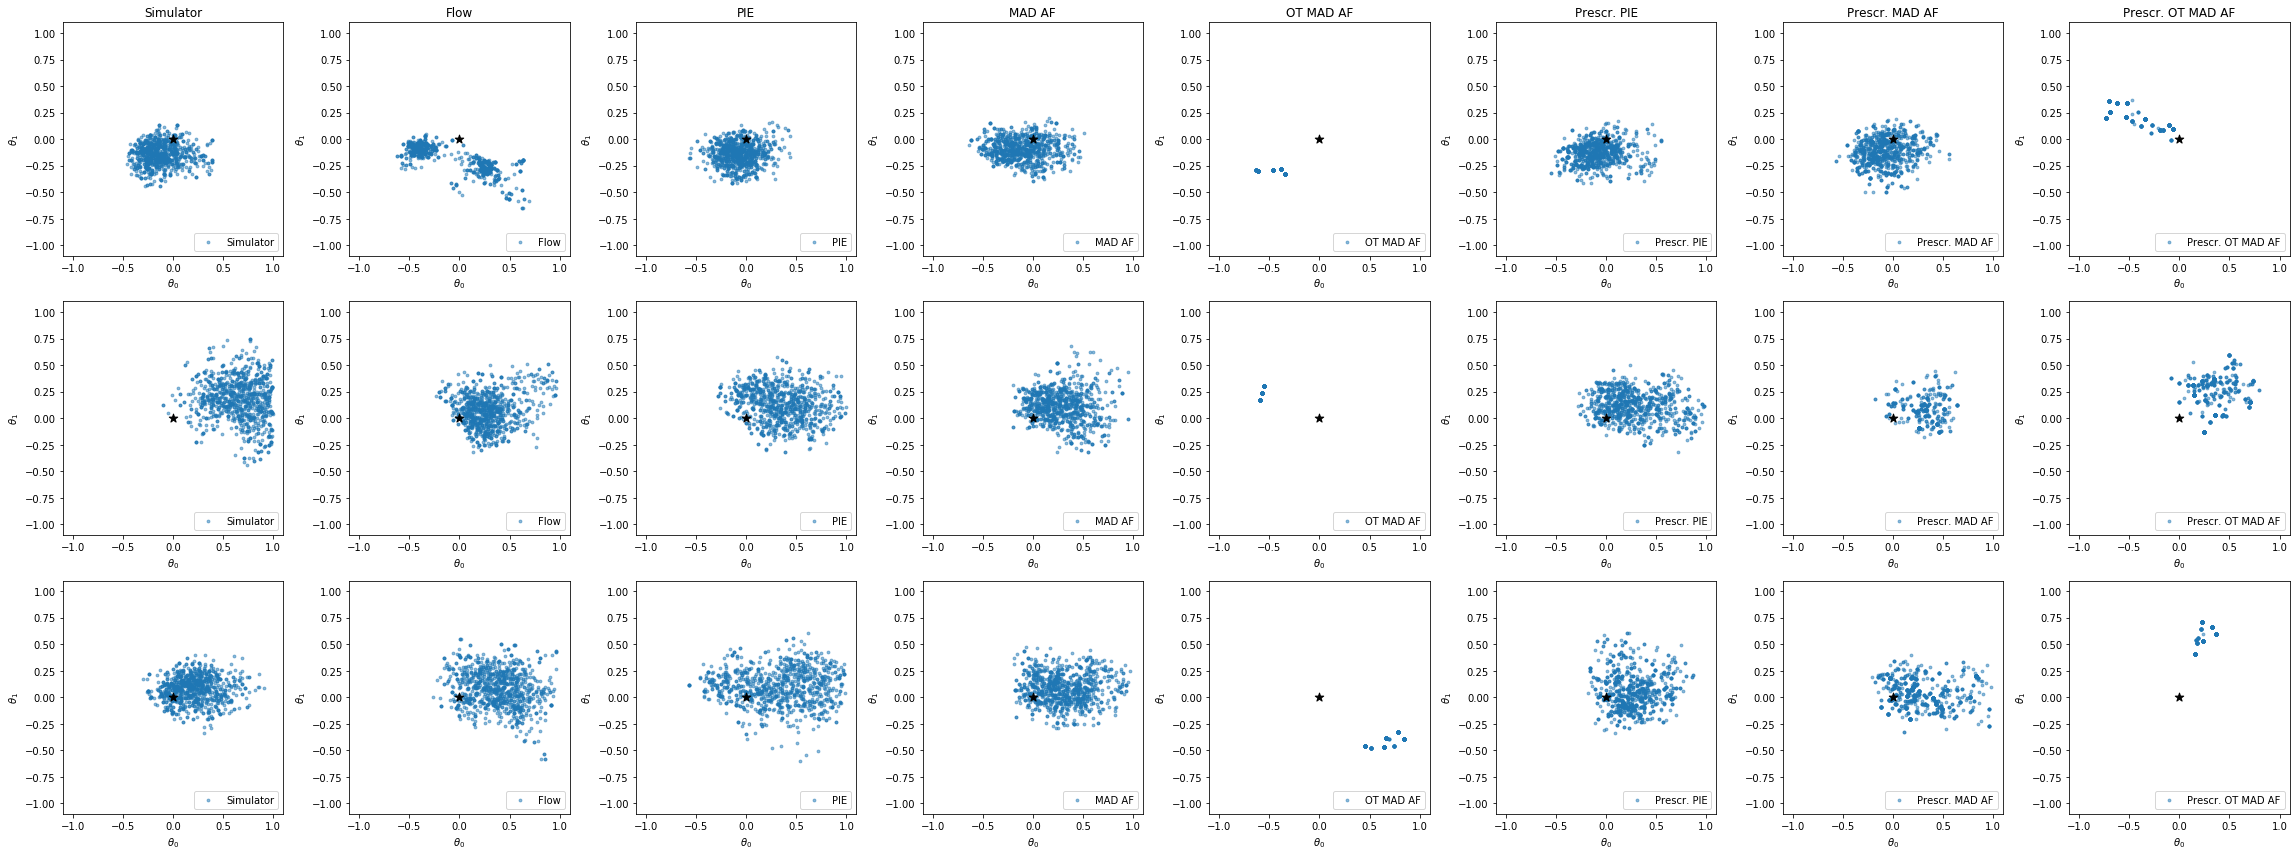

In [12]:
show = [1,0,2]

ncols = len(algo_labels) + 1
nrows = len(show)

fig = plt.figure(figsize=(ncols*4, nrows*4))

for row, setting in enumerate(show):
    for col, algo_label in enumerate(["Simulator"] + algo_labels):
        ax = plt.subplot(nrows, ncols, row*ncols + col + 1)

        if col == 0:
            plt.scatter(
                true_posterior_samples[col, setting,:,0],
                true_posterior_samples[col, setting,:,1],
                s=8., alpha=0.5, c="C0",
                label=algo_label
            )
        else:
            plt.scatter(
                model_posterior_samples[col - 1, setting,:,0],
                model_posterior_samples[col - 1, setting,:,1],
                s=8., alpha=0.5, c="C0",
                label=algo_label
            )
        plt.scatter([0.], [0.], s=80, marker="*", c="black")
        plt.legend(loc="lower right")
        
        plt.xlabel(r"$\theta_0$")
        plt.ylabel(r"$\theta_1$")
        plt.xlim(-1.1,1.1)
        plt.ylim(-1.1,1.1)
        
        if row == 0:
            ax.set_title(algo_label)
    
plt.tight_layout()
plt.savefig("../figures/posterior_samples_csg.pdf")


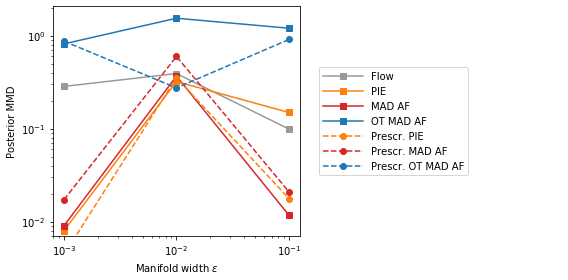

In [13]:
show = [1, 0, 2]
xs = [0.001, 0.01, 0.1]

fig = plt.figure(figsize=(8,4))

ax = plt.subplot(1,2,1)
for mmds_, algo_label, c, m, ls in zip(mmds, algo_labels, algo_colors, algo_markers, algo_linestyles):
    plt.plot(xs, mmds_[show], label=algo_label, c=c, ls=ls, marker=m, ms=6.)
# plt.legend(handlelength=3.)
plt.xscale("log")
plt.yscale("log")
plt.ylim(0.007, None)
plt.xlabel(r"Manifold width $\varepsilon$")
plt.ylabel("Posterior MMD")

ax = plt.subplot(1,2,2)
# plt.plot([], [], label="Simulator", ls=":", marker=" ", ms=6., c="black",zorder=5.)
for algo_label, c, m, ls in zip(algo_labels, algo_colors, algo_markers, algo_linestyles):
    plt.plot([], [], label=algo_label, ls=ls, marker=m, ms=6., c=c)
plt.legend(handlelength=4.,loc="center left")
plt.axis("off")

plt.tight_layout()
plt.savefig("../figures/metrics_csg.pdf")
